In [1]:
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow==2.5

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes 
from sklearn.metrics import roc_auc_score
import json
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

2021-08-20 16:21:04.649011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-20 16:21:04.649068: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()
    file.close()
    return text

In [5]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [7]:
data = read_text("fra.txt")
fr_eng = to_lines(data)
fr_eng = np.array(fr_eng)

In [8]:
fr_eng = fr_eng[:50000,:]

In [9]:
fr_eng = fr_eng[:, 0:2]

In [10]:
# Remove punctuation
fr_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fr_eng[:,0]]
fr_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fr_eng[:,1]]

In [11]:
# convert text to lowercase
for i in range(len(fr_eng)):
    fr_eng[i,0] = fr_eng[i,0].lower()
    fr_eng[i,1] = fr_eng[i,1].lower()

fr_eng

array([['go', 'va '],
       ['go', 'marche'],
       ['go', 'bouge '],
       ...,
       ['no one wants to fight', 'personne ne veut se battre'],
       ['no one wants to speak', 'personne ne veut parler'],
       ['no one was helping us', 'personne ne nous aidait']],
      dtype='<U349')

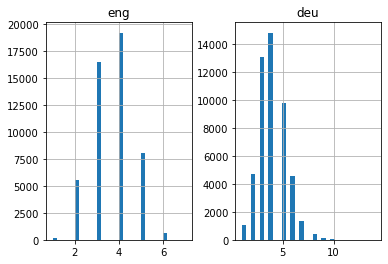

In [12]:
# empty lists
eng_l = []
fr_l = []

# populate the lists with sentence lengths
for i in fr_eng[:,0]:
    eng_l.append(len(i.split()))

for i in fr_eng[:,1]:
    fr_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':fr_l})

length_df.hist(bins = 30)
plt.show()

In [13]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [14]:
# prepare english tokenizer
eng_tokenizer = tokenization(fr_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 6
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6064


In [15]:
# prepare Deutch tokenizer
fr_tokenizer = tokenization(fr_eng[:, 1])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

fr_length = 6
print('Deutch Vocabulary Size: %d' % fr_vocab_size)

Deutch Vocabulary Size: 14037


In [16]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [17]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(fr_eng, test_size=0.2, random_state = 101)

In [18]:
# prepare training data
trainX = encode_sequences(fr_tokenizer, fr_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(fr_tokenizer, fr_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [19]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [20]:
# model compilation
model = define_model(fr_vocab_size, eng_vocab_size, fr_length, eng_length, 512)

2021-08-20 16:24:18.079637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-20 16:24:18.079728: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-20 16:24:18.079826: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e32cfa816c2f): /proc/driver/nvidia/version does not exist
2021-08-20 16:24:18.080217: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-20 16:24:18.099611: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28747776 excee

In [21]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
filename = 'model.fr.20_aug_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

2021-08-20 16:24:24.228041: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-20 16:24:24.228594: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699880000 Hz


Epoch 1/10


2021-08-20 16:24:26.218045: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28747776 exceeds 10% of free system memory.
2021-08-20 16:24:29.038983: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28747776 exceeds 10% of free system memory.


63/63 [==============================] - 85s 1s/step - loss: 4.3549 - val_loss: 3.7420

Epoch 00001: val_loss improved from inf to 3.74204, saving model to model.fr.20_aug_21


2021-08-20 16:25:54.591531: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


Epoch 2/10
63/63 [==============================] - 74s 1s/step - loss: 3.6449 - val_loss: 3.6038

Epoch 00002: val_loss improved from 3.74204 to 3.60381, saving model to model.fr.20_aug_21


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


Epoch 3/10
63/63 [==============================] - 74s 1s/step - loss: 3.4406 - val_loss: 3.4036

Epoch 00003: val_loss improved from 3.60381 to 3.40362, saving model to model.fr.20_aug_21


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


Epoch 4/10
63/63 [==============================] - 75s 1s/step - loss: 3.1997 - val_loss: 3.1959

Epoch 00004: val_loss improved from 3.40362 to 3.19593, saving model to model.fr.20_aug_21


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


Epoch 5/10
63/63 [==============================] - 75s 1s/step - loss: 3.0074 - val_loss: 3.0610

Epoch 00005: val_loss improved from 3.19593 to 3.06101, saving model to model.fr.20_aug_21


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


Epoch 6/10
63/63 [==============================] - 74s 1s/step - loss: 2.8384 - val_loss: 3.0117

Epoch 00006: val_loss improved from 3.06101 to 3.01175, saving model to model.fr.20_aug_21


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


Epoch 7/10
63/63 [==============================] - 73s 1s/step - loss: 2.6839 - val_loss: 2.8357

Epoch 00007: val_loss improved from 3.01175 to 2.83571, saving model to model.fr.20_aug_21


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


Epoch 8/10
63/63 [==============================] - 74s 1s/step - loss: 2.5383 - val_loss: 2.7892

Epoch 00008: val_loss improved from 2.83571 to 2.78921, saving model to model.fr.20_aug_21


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


Epoch 9/10
63/63 [==============================] - 72s 1s/step - loss: 2.4094 - val_loss: 2.6820

Epoch 00009: val_loss improved from 2.78921 to 2.68199, saving model to model.fr.20_aug_21


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


Epoch 10/10
63/63 [==============================] - 73s 1s/step - loss: 2.2853 - val_loss: 2.5867

Epoch 00010: val_loss improved from 2.68199 to 2.58667, saving model to model.fr.20_aug_21


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


INFO:tensorflow:Assets written to: model.fr.20_aug_21/assets


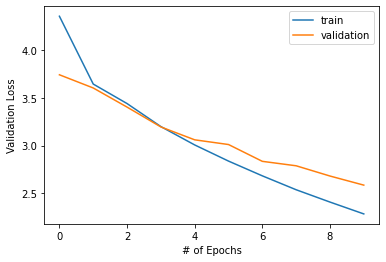

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('# of Epochs')
plt.ylabel('Validation Loss')
plt.show()

In [24]:
model = load_model('model.fr.20_aug_21')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

2021-08-20 16:56:45.172272: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-08-20 16:56:45.209904: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-08-20 16:56:45.226264: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-08-20 16:56:45.802654: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2021-08-20 16:56:45.820882: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond' has 5 outputs but the _output_sh

In [25]:
preds

array([[ 1, 19,  7,  0,  0,  0],
       [ 1,  1,  2,  0,  0,  0],
       [ 2, 23,  4,  4,  0,  0],
       ...,
       [ 1, 48,  2,  2,  0,  0],
       [17, 16,  0,  0,  0,  0],
       [ 1, 19,  4, 22,  0,  0]])

In [26]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [27]:
preds_text = []
for i in preds:
        temp = []
        for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                    temp.append('')
                else:
                    temp.append(t)
            else:
                    if(t == None):
                        temp.append('')
                    else:
                        temp.append(t) 

        preds_text.append(' '.join(temp))

In [28]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [42]:
# print 10 rows randomly
pred_df.sample(10)

,actual,predicted
9673,take care,lets away
79,shes wearing a hat,she is a
8541,is this worth doing,he is to
5707,its a new book,this is a
3685,im almost there,i am
6483,tom looks baffled,tom looks
4345,see you next week,get out the
1204,do you want a hand,do you have the
1717,im no different,im not
3507,the law is the law,the eyes is
